# Introducción

La predicción temprana de accidentes cerebrovasculares es un problema crítico dentro del ámbito de la salud pública. Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular constituye la segunda causa de muerte a nivel mundial y representa aproximadamente el 11% del total de fallecimientos globales. La posibilidad de anticipar estos eventos a partir de información clínica y demográfica habilita herramientas de prevención e intervención temprana.

En este trabajo práctico se desarrolla un modelo de aprendizaje automático orientado a predecir la probabilidad de que un paciente sufra un accidente cerebrovascular, utilizando como insumo el Stroke Prediction Dataset publicado en Kaggle. El objetivo es explorar las variables disponibles, realizar el preprocesamiento necesario, comparar distintas alternativas de modelado y finalmente seleccionar un algoritmo que permita obtener un desempeño robusto y clínicamente útil.

Fuente del dataset:
Federico Soriano, Stroke Prediction Dataset, Kaggle (2021).
Disponible en: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, ConfusionMatrixDisplay, precision_recall_curve, make_scorer, recall_score, fbeta_score

# AGREGO ESTO DESPUES DE HABER CORRIDO EL CODIGO COMPLETO Y EVALUADO TODOS LOS WARNINGS, SU OBJETIVO ES OCULTAR EL WARNING EN EL precision_recall_curve
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


El dataset contiene información de pacientes, tanto datos demográficos como factores de riesgo clínicos. Cada fila representa un individuo y cada columna un atributo relevante para la predicción. Las variables principales son:

Variables demográficas:

* gender: género del paciente
* age: edad del paciente
* ever_married: si alguna vez estuvo casado
* work_type: tipo de ocupación
* Residence_type: tipo de residencia (urbana o rural)

Variables clínicas:

* hypertension: presencia de hipertensión
* heart_disease: presencia de enfermedad cardíaca
* avg_glucose_level: nivel promedio de glucosa en sangre
* bmi: índice de masa corporal

Hábitos y estilo de vida:
* smoking_status: categoría de consumo de tabaco

Variable objetivo:

* stroke: indica si el paciente sufrió un accidente cerebrovascular (1) o no (0)

El dataset presenta un desbalance significativo, con un porcentaje muy bajo de casos positivos (5%), lo cual condiciona el tipo de modelos y métricas a utilizar.


# EDA

In [2]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [3]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [4]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())


print(df['work_type'])

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

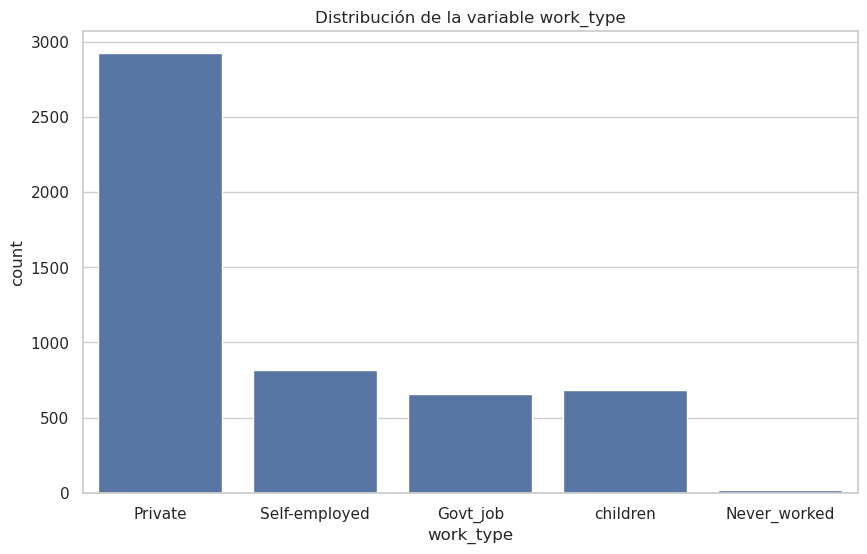

In [5]:
sns.countplot(x='work_type', data=df)
plt.title('Distribución de la variable work_type')
plt.show()

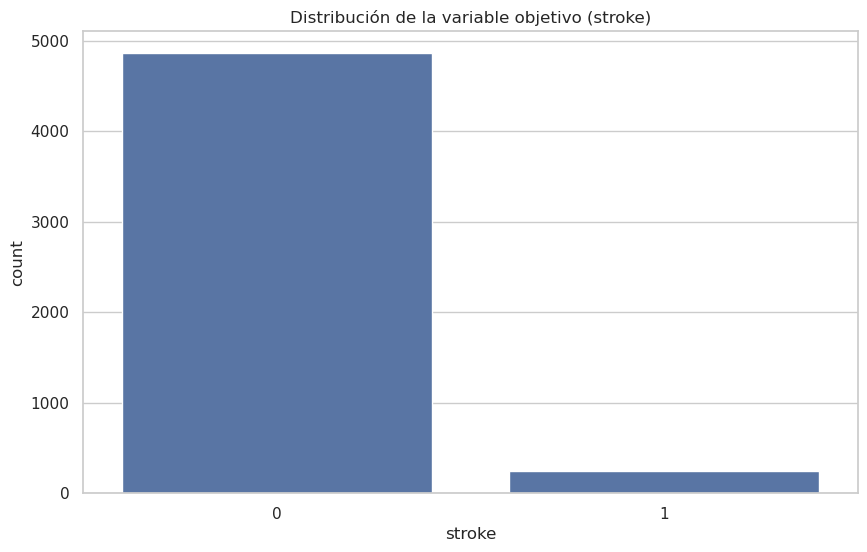

In [6]:
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


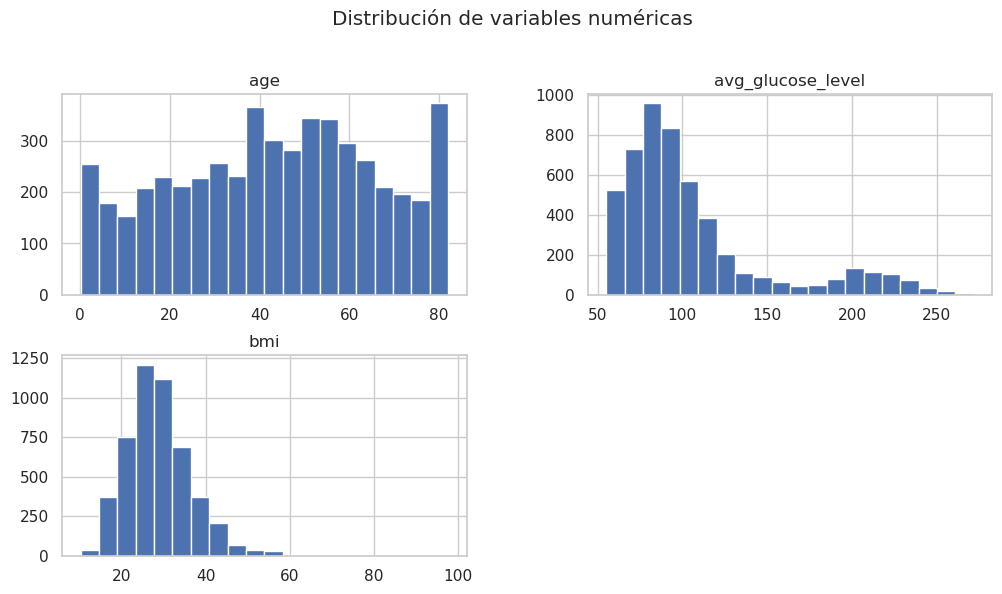

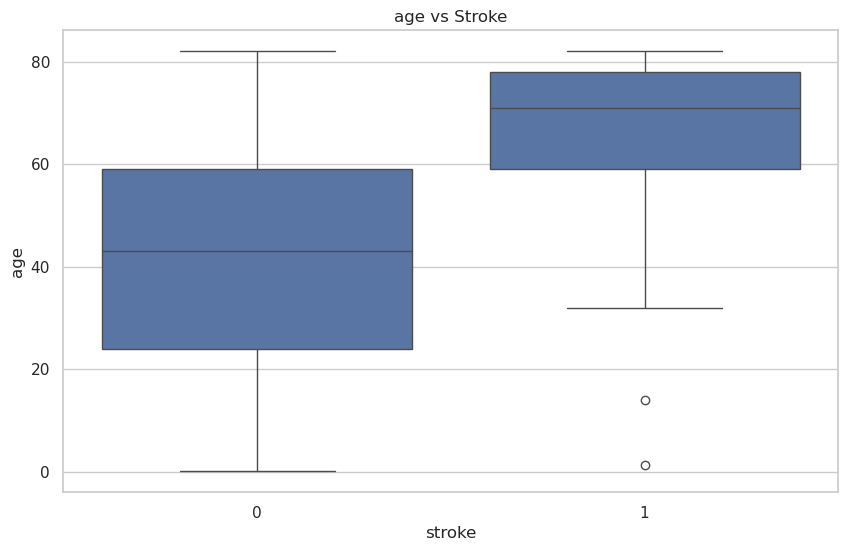

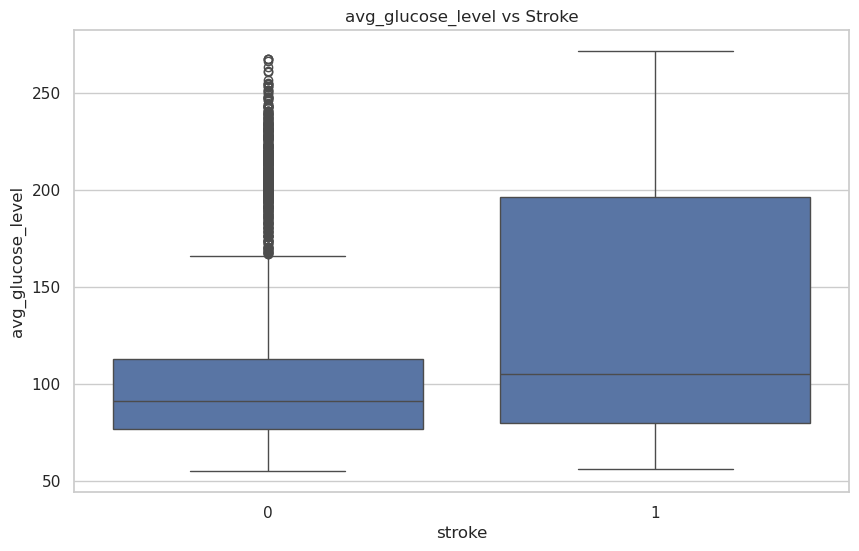

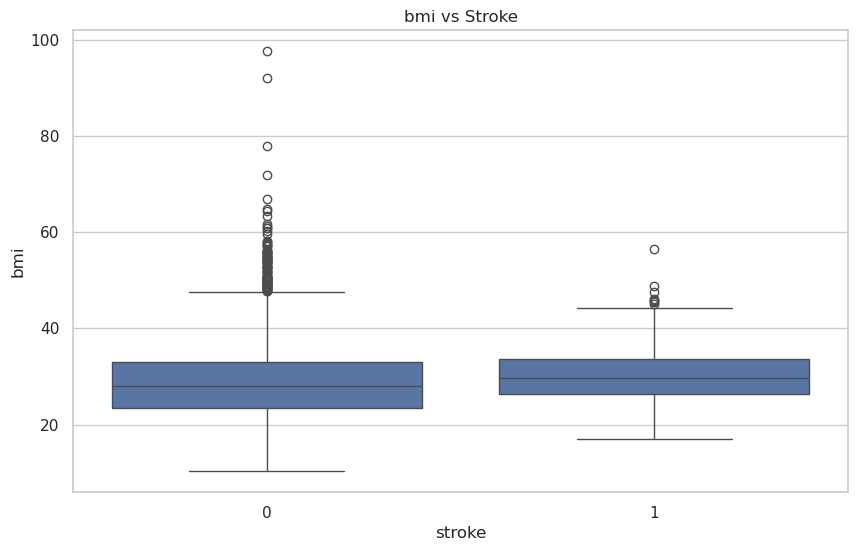

In [7]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

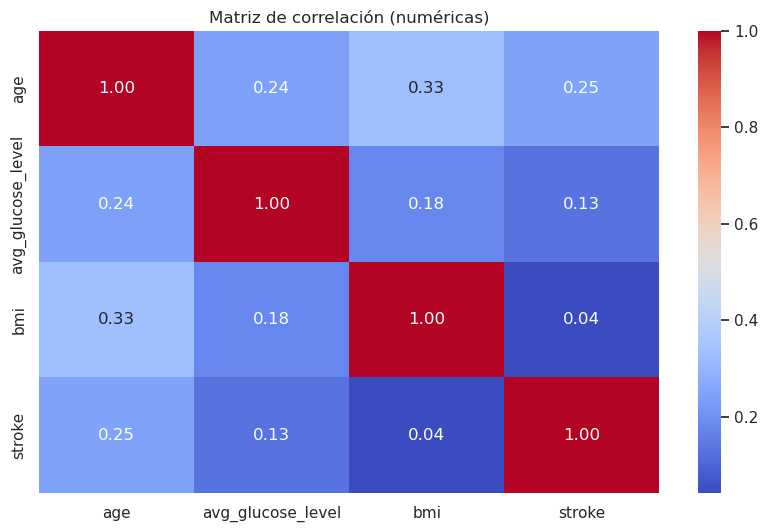

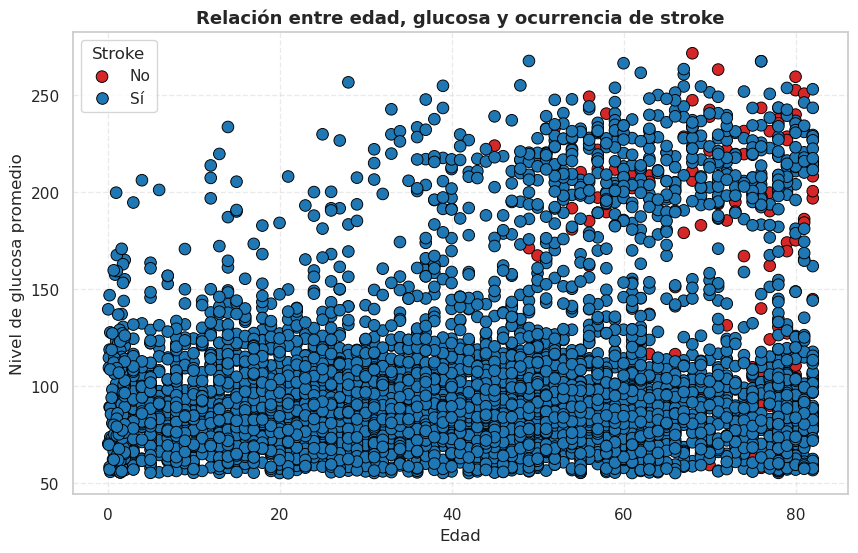

In [8]:
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=70  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Distribuciones categoricas vs Target

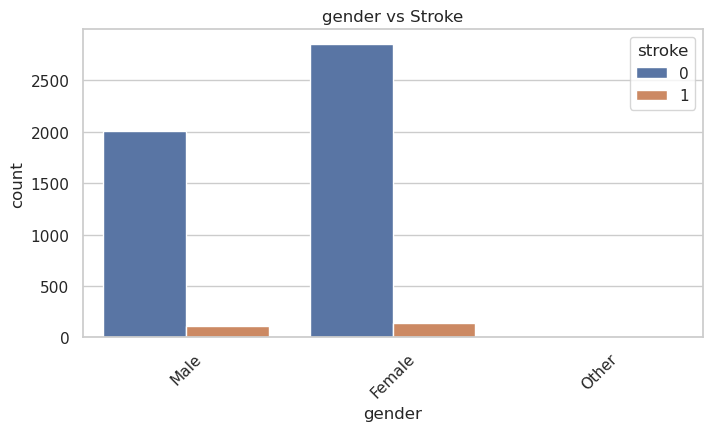

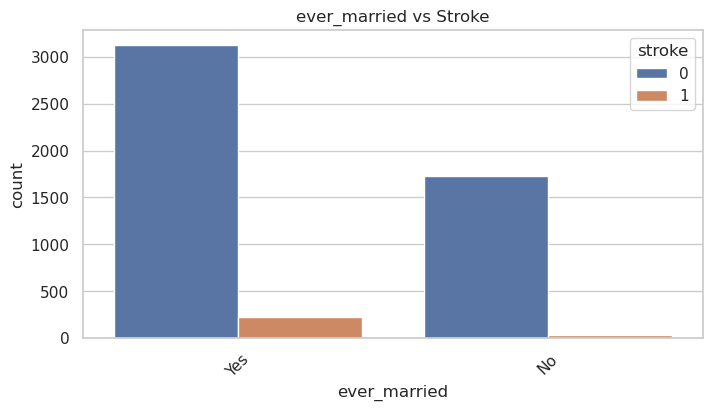

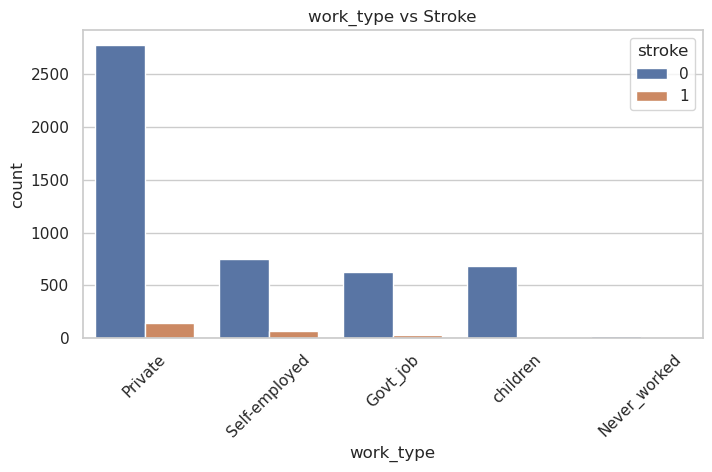

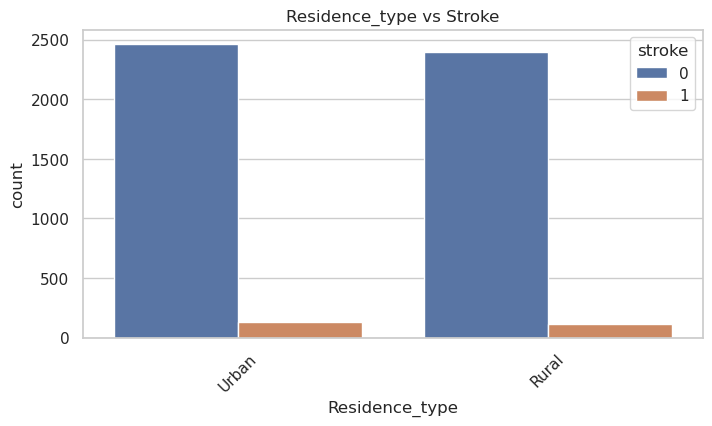

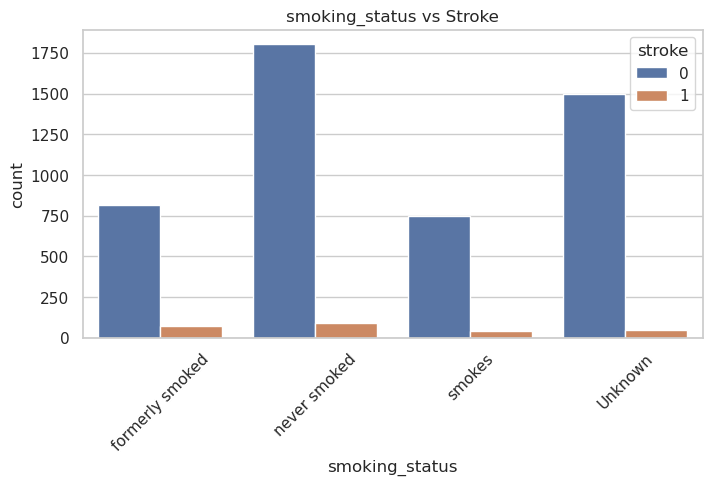

In [9]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.show()

# Se separa el set de entrenamiento del de testeo

Previo a las transformaciones y balanceo de los datos, se procede a crear una divison entre los sets de testeo y entrenamiento

In [10]:
# Pensemos si queremos cambiar el 0.3 a otro valor
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Primero: train + valid vs test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Luego: train vs valid
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp)

# Transformaciones y tratamiento de Nulls

Con el objetivo de proveer datos numericos y validos al modelo de entrenamiento, utilizamos la media para rellenar los valores de BMI y most_frequent para las variables categoricas. Luego escalamos los valores numericos y aplicamos One-Hot encoding a las variables categoricas dado que tienen una baja cardinalidad.

In [11]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'Residence_type',
                'smoking_status', 'work_type']

# se imputan valores faltantes con median + escalar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# se imputan valores faltantes + One-Hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Modelo y Pipeline

Para este problema se utiliza un Random Forest Classifier, por las siguientes razones:

* El problema es de clasificación binaria con variables tanto numéricas como categóricas. Random Forest maneja naturalmente ambos tipos sin requerir transformaciones complejas.
* El dataset presenta relaciones no lineales entre las variables clínicas (por ejemplo, glucosa, BMI, edad), y los árboles permiten capturar estas interacciones sin necesidad de ingeniería de features adicional.
* El algoritmo es robusto al ruido, a outliers y a escalado desigual entre variables.
* Soporta bien el desbalance mediante el parámetro class_weight='balanced', lo cual es importante para no ignorar los casos de stroke.

Por estas razones, el Random Forest se presenta como un buen compromiso entre interpretabilidad, precisión, robustez y capacidad de generalización.

In [12]:
modelo_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'   # mucho más rápido
)

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', modelo_xgb)
])

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

parametros_grid_xgb = {
    'clf__n_estimators': [200, 400, 600],
    'clf__max_depth': [3, 5, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.7, 0.9, 1.0],
    'clf__colsample_bytree': [0.7, 0.9, 1.0],
    'clf__gamma': [0, 1, 3],
    'clf__min_child_weight': [1, 3, 5],
    'clf__scale_pos_weight': [1, 3, 5]   # reemplaza el class_weight
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid_search_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=parametros_grid_xgb,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

print("Mejores hiperparámetros XGBoost:")
print(grid_search_xgb.best_params_)

y_pred_val = best_xgb.predict(X_val)


Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Mejores hiperparámetros XGBoost:
{'clf__colsample_bytree': 0.9, 'clf__gamma': 3, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_child_weight': 1, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 5, 'clf__subsample': 1.0}


Mejor threshold en VALIDACIÓN: 0.325
F2 en VALIDACIÓN con ese threshold: 0.4636


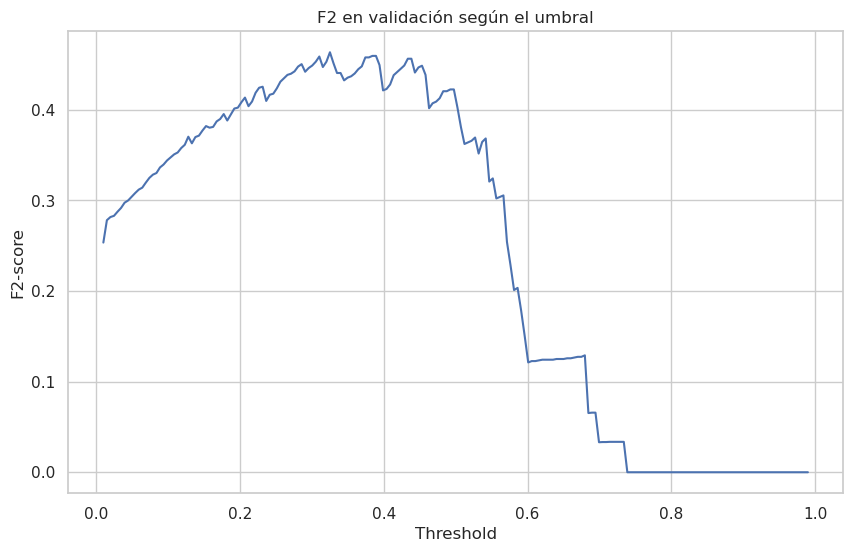

In [13]:
y_proba_val = best_xgb.predict_proba(X_val)[:, 1]

betascore = []
thresholds = np.linspace(0.01, 0.99, 200)  # 200 thresholds entre 0.01 y 0.99

for thr in thresholds:
    y_pred_val_thr = (y_proba_val >= thr).astype(int)
    f2 = fbeta_score(y_val, y_pred_val_thr, beta=2)
    betascore.append(f2)

best_idx = int(np.argmax(betascore))
best_threshold = thresholds[best_idx]
best_f2_val = betascore[best_idx]

print(f"Mejor threshold en VALIDACIÓN: {best_threshold:.3f}")
print(f"F2 en VALIDACIÓN con ese threshold: {best_f2_val:.4f}")

plt.plot(thresholds, betascore)
plt.xlabel("Threshold")
plt.ylabel("F2-score")
plt.title("F2 en validación según el umbral")
plt.grid(True)
plt.show()

## Se entrena el modelo y predecimos

In [14]:
y_proba_test = best_xgb.predict_proba(X_test)[:, 1]
threshold = 0.32
y_pred_test = (y_proba_test >= threshold).astype(int)

## Se analisa los resultados mediante curva ROC, Precision-Recall y matriz de confusion

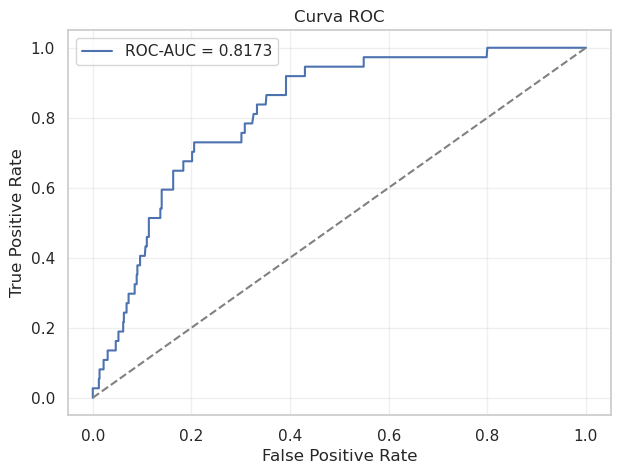

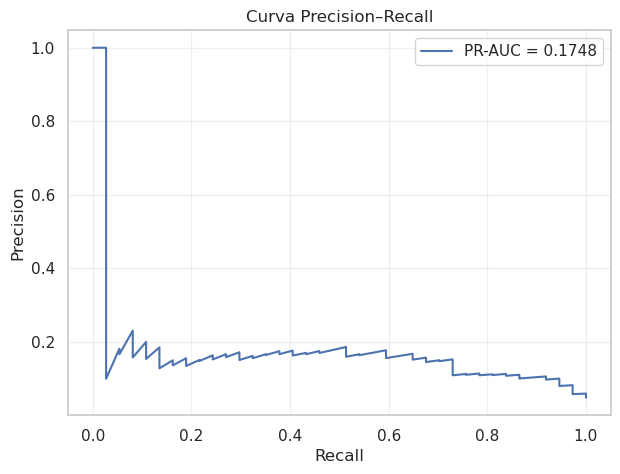

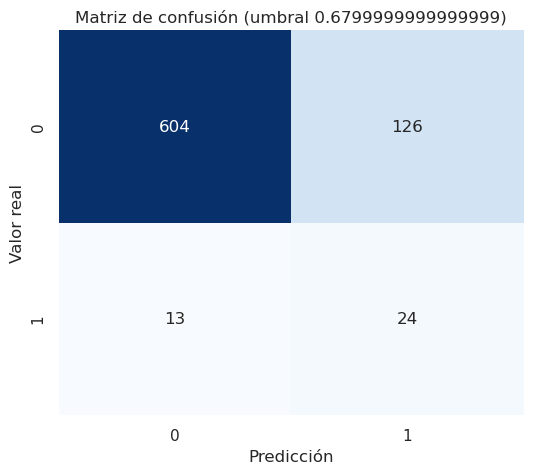

In [15]:
#curva roc

roc_auc = roc_auc_score(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# precision - recall

precision, recall, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#matriz de confusion

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión (umbral {1 - threshold})")
plt.show()

# Conclusion

...